# Introduction

A 3-1-1 number is a special number used in many communities in the United States of America and Canada. It provides residents with access to non-emergency municipal services and diverts general inquiries and non-urgent issues away from 9-1-1, which is dedicated to emergency services. <br><br>
This report aims to emphasize important statistics of 3-1-1 service requests made by Boston residents in 2021. I would like to analyze the most popular complaint category type, location, and how these requests are processed by the government. <br><br>
Each row in the dataset represents a service request generated by a resident or staff member in any mode. There are in total 29 parameters such as creation date, status, subject, department, location, and source used to maintain data for each request. By scanning the dataset, it is possible to observe that requests arrive at a common pool of requests before being routed to department-specific queues based on the requests’ type and location.<br>

# Dataset Overview

Analyze Boston is a treasure trove of publicly available City government datasets. 311 Service requests are one such dataset. Each row in the dataset represents a service request submitted by individuals or staff via a variety of channels, including phone calls, apps, and websites. These 311 data are updated daily and include information on over 273 thousand service requests and 29 parameters for the year 2021.

# Data Preparation

## Importing all required Libraries

In [1]:
#Loading packages:
import numpy as np #Importing 'Numpy' Library that will be used to perform mathematical operations.
import pandas as pd #Importing 'Pnadas' Library to perform data manupalation and analysis.
import datetime as dt #Importing 'Datetime' Library that will help to perform operations on date variables.
import re #importing 'Regular Expression' Library that will help to perform data cleaning operations.
import warnings
import geopandas as gpd #importing geopandas to work with geospatial data easily.
import matplotlib as mp #importing matplotlib to plot data into a graphical representation.
from matplotlib import pyplot as plt
%matplotlib inline

## Importing Data

In [2]:
#Loading 311 service requests data.
ogfilename = 'og_311_ServiceRequest_2021.csv' #Creating a variable to store path and name of the dataset.
service_request_df = pd.read_csv(ogfilename, dtype={'location_zipcode': 'str'},low_memory = False) 
#With the help of 'Pandas read_csv()' function to read the csv data and store in a new dataframe. 
#Here we are importing zip codes as string/object to avoid any errors while importing data.

In [3]:
#Loading Boston Neighborhood geographical data.
df_places = gpd.read_file('Boston_Neighborhoods.geojson') #Creating a variable to store path and name of the dataset.

# Descriptive Analysis

## 311 service request data exploration

service_request_df.info() 
#With the help of info() function we are extracting the structure, column data type and number of values present in each rows.

Utilizing Pandas **info()** method, we can see that there are **273951** data rows and **29** columns, and it is using more than **60.6 MB** of memory.At first sight, the data are of three types: *int64, float64, and object*. There are numerous columns with missing data that must be addressed before proceeding to the analysis phase.
 </div>

service_request_df.head()

With the help of **head()** function we can look how the data looks.

## Boston Neighbourhood geographical data exploration


df_places.info()

We could observe that there are **26** data rows and **7** columns. At first sight, the data are of three types: *int64, geometry, and object*.
 </div>

In [4]:
df_places.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ..."
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335..."
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337..."
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06663 42.348..."


# Data Cleaning & Transformation

## Dropping Unwanted Columns

While drafting the objectives of my project, I noted down which columns would be required and which would not be required, based on this observation I decided to drop all the columns that are not required for my analysis. This helped to lower my memory usage from 60.4 MB to 46 MB.

In [5]:
#Dropping not required columns from the data frame.
service_request_df.drop(['submittedphoto','closedphoto','fire_district','pwd_district','city_council_district',
                         'police_district','precinct'],axis = 1,inplace = True) 
#With the help of drop() function we are droping irrelevant columns and passing attributes as 'axis = 1' that indicates columns.
service_request_df.columns

Index(['case_enquiry_id', 'open_dt', 'target_dt', 'closed_dt', 'ontime',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'location', 'neighborhood',
       'neighborhood_services_district', 'ward', 'location_street_name',
       'location_zipcode', 'latitude', 'longitude', 'source'],
      dtype='object')

In [6]:
service_request_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273951 entries, 0 to 273950
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   case_enquiry_id                 273951 non-null  int64  
 1   open_dt                         273951 non-null  object 
 2   target_dt                       238320 non-null  object 
 3   closed_dt                       244729 non-null  object 
 4   ontime                          273951 non-null  object 
 5   case_status                     273951 non-null  object 
 6   closure_reason                  273951 non-null  object 
 7   case_title                      273945 non-null  object 
 8   subject                         273951 non-null  object 
 9   reason                          273951 non-null  object 
 10  type                            273951 non-null  object 
 11  queue                           273951 non-null  object 
 12  department      

## Data Type Correction

When I reviewed the data type of each column after removing irrelevant columns, I discovered that the data in the data frame was not properly linked since date variables were marked as an object. While converting data, let us just look at which columns would be good candidates for a categorical data type by counting the number of unique entries/values in each column and determining whether any columns are unnecessary. I opted to convert all variables with fewer than 175 unique entries to categorical data types with the help of the 'FOR' loop.

In [7]:
unique_counts = pd.DataFrame.from_records([(col, service_request_df[col].nunique()) for col in service_request_df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
4,ontime,2
5,case_status,2
21,source,6
8,subject,11
12,department,16
15,neighborhood_services_district,17
14,neighborhood,24
18,location_zipcode,34
9,reason,45
16,ward,56


Correcting variables with Date values

In [8]:
#There are 3 columns that holds date values hence we need to convert them to datetime data type.
service_request_df['open_dt'] = service_request_df['open_dt'].astype('datetime64[ns]')
service_request_df['target_dt'] = service_request_df['target_dt'].astype('datetime64[ns]')
service_request_df['closed_dt'] = service_request_df['closed_dt'].astype('datetime64[ns]')

Converting the object variables with less than 175 unique values to the categorical data type with the help of the ‘FOR’ Loop:

In [9]:
cols_to_exclude = ['open_dt','target_dt','closed_dt','location_zipcode'] #Columns to be excluded.
#With the help of 'for' loop we are parsing each column and finding number of unique data in that particular column and then if the count it less than 60 unique values we are converting it into categorical data type.
for col in service_request_df.columns:
    if service_request_df[col].nunique() < 175 and col not in cols_to_exclude:
        #print (f'{col} have {service_request_df[col].nunique()} unique values')
        service_request_df[col] = service_request_df[col].astype('category')

## Handling NULL Values

Once the variable data types were corrected, I proceeded to check NULL values using the built-in function '.isna(),' however the program was unable to capture the white spaces present in many rows. To replace data from multiple columns I used the ‘FOR’ loop.

In [10]:
service_request_df['closure_reason'].replace(' ', np.nan, inplace = True)
service_request_df['location'].replace(' ', np.nan, inplace = True)
service_request_df['neighborhood'].replace(' ', np.nan, inplace = True)


cols_to_exclude = ['closure_reason','location','neighborhood'] #Columns to be excluded.
#With the help of 'for' loop we are parsing each column and finding number of unique data in that particular column and then if the count it less than 60 unique values we are converting it into categorical data type.
for col in service_request_df.columns:
    service_request_df[col].replace(' ', np.nan, inplace = True)

In [11]:
service_request_df.isna().sum()

case_enquiry_id                       0
open_dt                               0
target_dt                         35631
closed_dt                         29222
ontime                                0
case_status                           0
closure_reason                    29043
case_title                            6
subject                               0
reason                                0
type                                  0
queue                                 0
department                            0
location                           2822
neighborhood                       3065
neighborhood_services_district     2844
ward                               2822
location_street_name               2822
location_zipcode                  61070
latitude                              0
longitude                             0
source                                0
dtype: int64

After running the above code many missing data points were marked as ‘np.NaN’.

## Converting Data to Lowercase

I used the ‘.lower()' function to transform all data from the object data type to lowercase so that I could get consistent results.

In [12]:
for i in service_request_df.columns:
    if ((service_request_df.dtypes[i] == 'object') or (service_request_df.dtypes[i] == 'category')):
        service_request_df[i] = service_request_df[i].str.lower()
service_request_df

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,department,location,neighborhood,neighborhood_services_district,ward,location_street_name,location_zipcode,latitude,longitude,source
0,101003578872,2021-01-01 00:06:37,2021-01-06 08:30:00,2021-01-01 05:36:42,ontime,closed,case closed. closed date : fri jan 01 05:36:42...,improper storage of trash (barrels),public works department,code enforcement,...,pwdx,797 columbia rd dorchester ma 02125,dorchester,5,ward 7,797 columbia rd,02125,42.3202,-71.0572,citizens connect app
1,101003578875,2021-01-01 00:15:47,2021-01-05 08:30:00,2021-01-02 12:49:26,ontime,closed,case closed. closed date : 2021-01-02 12:49:26...,parking enforcement,transportation - traffic division,enforcement & abandoned vehicles,...,btdt,50 newton st brighton ma 02135,allston / brighton,15,ward 22,50 newton st,02135,42.3569,-71.1650,citizens connect app
2,101003578879,2021-01-01 00:26:46,NaT,2021-01-04 13:56:41,ontime,closed,case closed. closed date : 2021-01-04 13:56:41...,notification,mayor's 24 hour hotline,notification,...,info,693 dudley st dorchester ma 02125,dorchester,13,13,693 dudley st,02125,42.3594,-71.0587,constituent call
3,101003578880,2021-01-01 00:27:00,NaT,2021-03-18 03:02:40,ontime,closed,case closed case noted,fire,mayor's 24 hour hotline,notification,...,info,intersection of nonquit st & dudley st dorche...,dorchester,13,7,intersection nonquit st & dudley st,NaN,42.3594,-71.0587,constituent call
4,101003578881,2021-01-01 00:36:34,2021-01-07 08:30:00,2021-01-01 05:43:25,ontime,closed,case closed. closed date : fri jan 01 05:43:25...,poor conditions of property,public works department,code enforcement,...,pwdx,83-93 stoughton st dorchester ma 02125,dorchester,7,ward 13,83-93 stoughton st,02125,42.3157,-71.0623,citizens connect app
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273946,101004113290,2021-12-31 22:58:00,NaT,NaT,ontime,open,NaN,loud parties/music/people,boston police department,noise disturbance,...,info,11 abbotsford st dorchester ma 02121,roxbury,13,ward 12,11 abbotsford st,02121,42.3144,-71.0924,constituent call
273947,101004113292,2021-12-31 23:12:00,2022-01-30 23:12:18,2022-01-03 09:15:35,ontime,closed,case closed. closed date : 2022-01-03 09:15:35...,no utilities residential - water,inspectional services,housing,...,isd,884 cummins hwy mattapan ma 02126,greater mattapan,9,ward 18,884 cummins hwy,02126,42.2690,-71.0957,constituent call
273948,101004113294,2021-12-31 23:30:00,2022-01-17 08:30:00,2022-01-04 16:32:27,ontime,closed,case closed. closed date : 2022-01-04 16:32:27...,street light outages,public works department,street lights,...,info,intersection of morton st & norfolk st mattap...,greater mattapan,9,14,intersection morton st & norfolk st,NaN,42.3594,-71.0587,citizens connect app
273949,101004113295,2021-12-31 23:42:00,2022-01-17 08:30:00,2022-01-03 09:52:47,ontime,closed,case closed. closed date : mon jan 03 09:52:47...,printed : street light outages - ep,public works department,street lights,...,pwdx,34 torrey st dorchester ma 02124,dorchester,9,ward 17,34 torrey st,02124,42.2872,-71.0728,employee generated


## Adding New Columns

I added new columns for my analysis mostly they were related to the date and time fields.

In [13]:
#Adding this two new columns to fetch the month and month letter from the open_dt variable.
service_request_df['DUMMY_open_dt_month_letter'] = service_request_df['open_dt'].dt.month_name()
service_request_df['DUMMY_open_dt_month'] = service_request_df['open_dt'].dt.month
service_request_df['DUMMY_close_dt_month_letter'] = service_request_df['closed_dt'].dt.month_name()
service_request_df['DUMMY_close_dt_month'] = service_request_df['closed_dt'].dt.month
#Adding a new column to calculate the aproximate days took to close the requests.
service_request_df['aprx_days']= service_request_df['closed_dt'] - service_request_df['open_dt']

# Analysis

## Preferred mode of requests?

In [14]:
preferredmodedf = service_request_df.groupby(['source'],as_index = False)['case_enquiry_id'].count().sort_values('case_enquiry_id',ascending = False)
#Here we are grouping the data as per the source to count the number of requests as per the source and saving the result in a new dataframe.
preferredmodedf

,source,case_enquiry_id
0,citizens connect app,132992
2,constituent call,100674
1,city worker app,24496
5,self service,8662
3,employee generated,7126
4,maximo integration,1


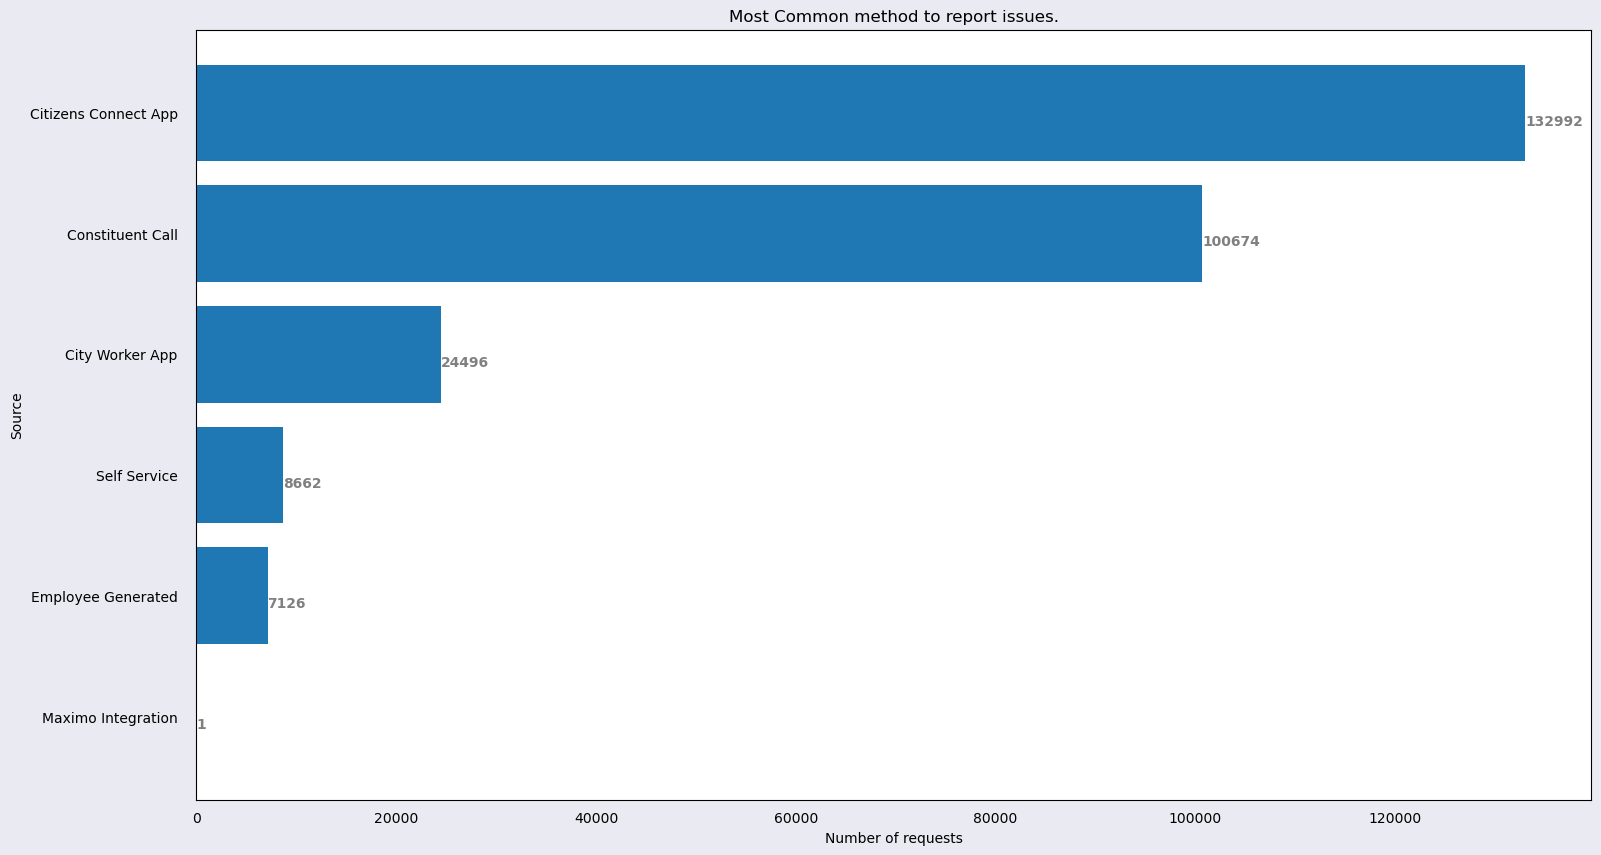

In [15]:
#Plot Graph
#fetching the values into a variable.
facecolor = '#eaeaf2'
source = preferredmodedf['source'].str.title()
numberofrequests = preferredmodedf['case_enquiry_id']
#
fig1, ax1 = plt.subplots(figsize=(18, 10),facecolor=facecolor)

ax1.barh(source,numberofrequests)
    
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax1.xaxis.set_tick_params(pad=5)
ax1.yaxis.set_tick_params(pad=10)


ax1.invert_yaxis()


for i in ax1.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
ax1.set_ylabel('Source')
ax1.set_xlabel('Number of requests')
ax1.set_title('Most Common method to report issues.',
             loc='center')

#Saving file.
filename = 'q1-most-preffered-method-to-raise-request'
plt.savefig(filename+'.png', facecolor=facecolor)

The ‘Citizen Connect App’ i.e BOS:311 App is the most preferred mode of requesting non-emergency requests throughout the city of Boston.

## In 2021, how many requests were made?

In [16]:
#Here we are calculating the total number of requests received in 2021 and groupuing by case_status
reqstatusdf = service_request_df[['case_status']].value_counts().reset_index().rename(columns = {0 : 'Count'})
reqcompstatusdf =service_request_df[['case_status','ontime']].value_counts().reset_index().rename(columns = {0 : 'requests_count'})
reqcompstatusdf

,case_status,ontime,requests_count
0,closed,ontime,221186
1,closed,overdue,23543
2,open,overdue,21823
3,open,ontime,7399


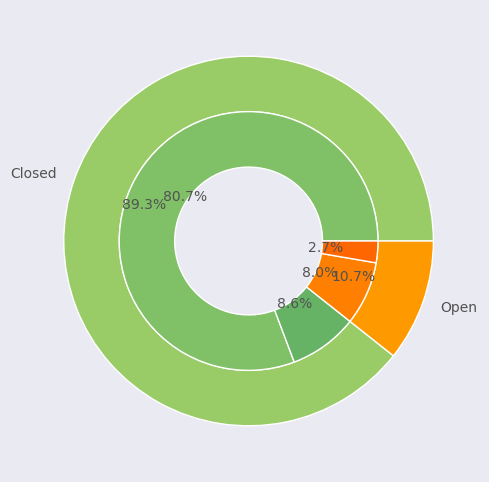

In [17]:
#Plotting Pie chart
facecolor = '#eaeaf2'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
labels_outer = ['Closed','Open']
labels_inner = ['Ontime','Overdue']
size = 0.3
vals = reqcompstatusdf['requests_count']
# Major category values = sum of minor category values
group_sum = reqstatusdf['Count']
    
fig, ax = plt.subplots(figsize=(10,6), facecolor=facecolor)
        
a,b = [plt.cm.summer, plt.cm.autumn]

outer_colors = [a(.6), b(.6)]
inner_colors = [a(.5), a(.4), 
                b(.5), b(.4)]
        
ax.pie(group_sum, 
       radius=1, 
       colors=outer_colors, 
       labels=labels_outer,
       autopct='%1.1f%%',
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals, 
       radius=1-size, # size=0.3       
       autopct='%1.1f%%',
       colors=inner_colors,
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'))
#Saving image      
filename = 'request-status-as-of-31stdec-21'
plt.savefig(filename+'.png', facecolor=facecolor)  
    

In the year 2021, a total of 2,73,951 requests were received, with 89.3% of the requests closed and only 2.7% of the requests opened being overdue. Based on this computation, it is reasonable to conclude that the city council actively responds to citizen requests.

## Analysis of requests on a monthly basis

Let's have a look at the number of requests received and closed on a monthly basis. While analyzing the closed requests, I discovered that there were around 29,222 records with missing dates; however, with further investigation, I discovered that the dates were missing only for the open requests.

Request Inflow

In [18]:
monthlyrequestsopen = service_request_df[['DUMMY_open_dt_month_letter','DUMMY_open_dt_month']].value_counts().reset_index().rename(columns = {0 : 'Count'}).sort_values(by = 'DUMMY_open_dt_month',ascending = True)
monthlyrequestsopen

,DUMMY_open_dt_month_letter,DUMMY_open_dt_month,Count
10,January,1,17899
9,February,2,17915
7,March,3,21745
6,April,4,22391
5,May,5,23073
4,June,6,24400
2,July,7,26416
1,August,8,27951
0,September,9,28812
3,October,10,24521


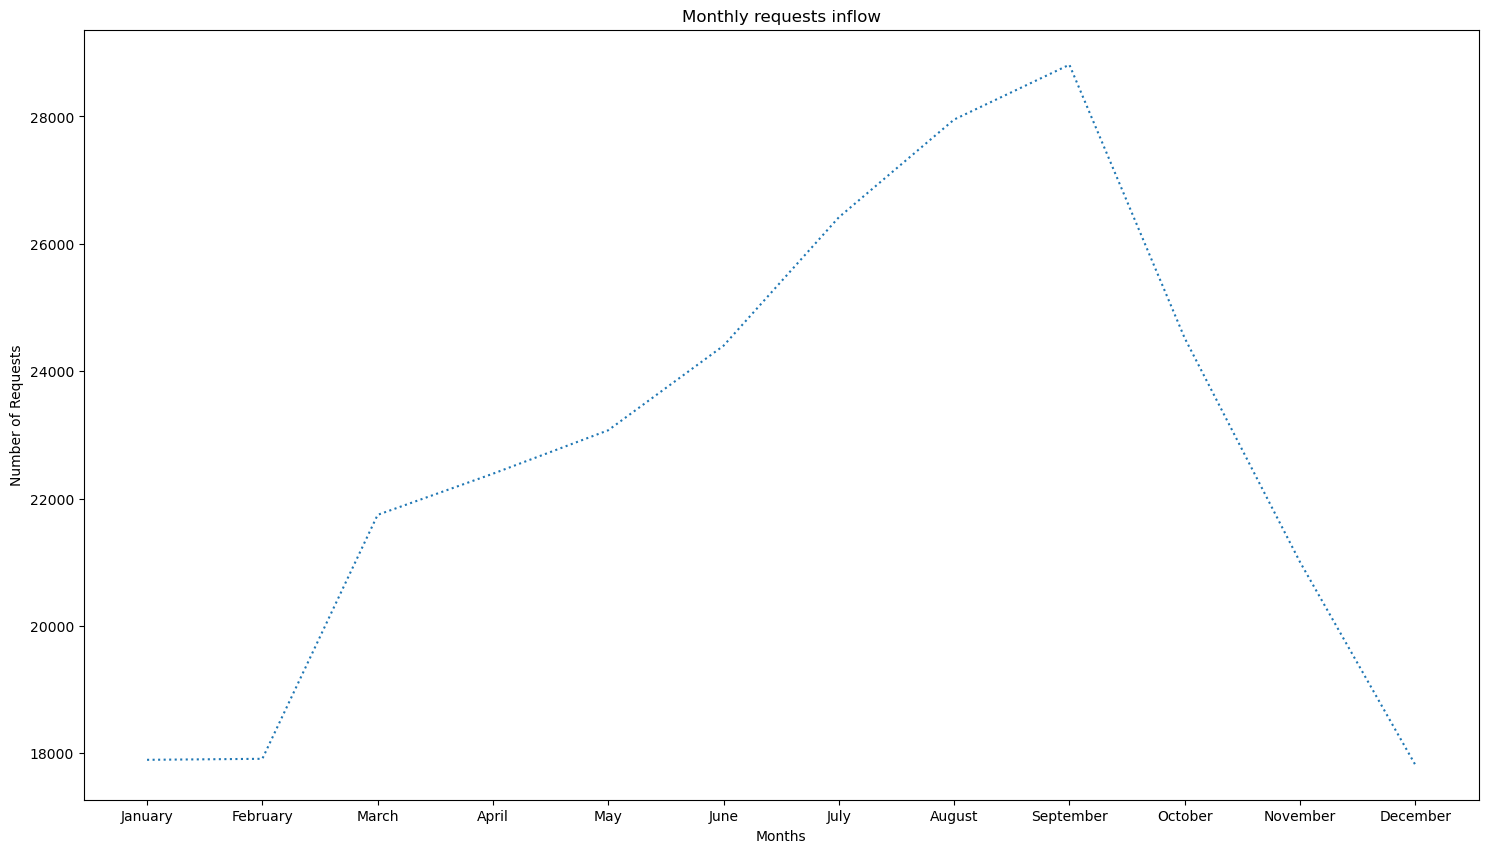

In [19]:
x = monthlyrequestsopen['DUMMY_open_dt_month_letter']
y = monthlyrequestsopen['Count']
fig1, ax2 = plt.subplots(figsize=(18, 10))
plt.plot(x,y, linestyle = 'dotted')
ax2.set_ylabel('Number of Requests')
ax2.set_xlabel('Months')
ax2.set_title('Monthly requests inflow',
             loc='center')
#Saving image      
filename = 'monthly-request-open'
plt.savefig(filename+'.png', facecolor=facecolor) 

Requests Closed

In [20]:
monthlyrequestsclose = service_request_df[['DUMMY_close_dt_month_letter','DUMMY_close_dt_month']].value_counts().reset_index().rename(columns = {0 : 'Count'}).sort_values(by = 'DUMMY_close_dt_month',ascending = True)
monthlyrequestsclose

,DUMMY_close_dt_month_letter,DUMMY_close_dt_month,Count
11,January,1.0,14865
10,February,2.0,16162
8,March,3.0,18814
7,April,4.0,19677
5,May,5.0,20231
4,June,6.0,22034
2,July,7.0,22985
1,August,8.0,24714
0,September,9.0,26536
3,October,10.0,22320


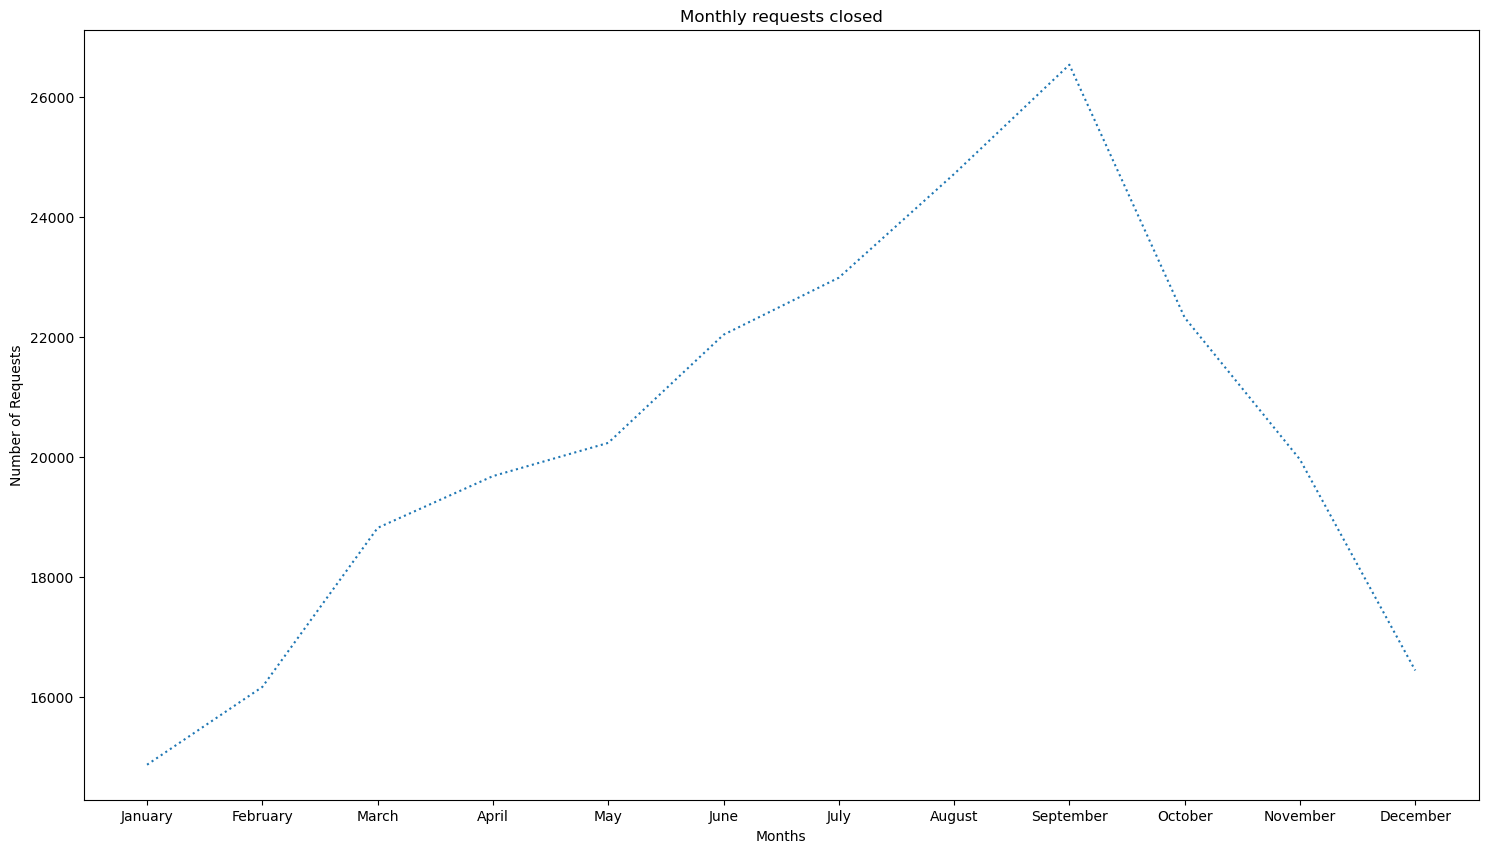

In [21]:
x = monthlyrequestsclose['DUMMY_close_dt_month_letter']
y = monthlyrequestsclose['Count']
fig1, ax2 = plt.subplots(figsize=(18, 10))
plt.plot(x,y, linestyle = 'dotted')
ax2.set_ylabel('Number of Requests')
ax2.set_xlabel('Months')
ax2.set_title('Monthly requests closed',
             loc='center')
#Saving image      
filename = 'monthly-request-closed'
plt.savefig(filename+'.png', facecolor=facecolor) 

The following plots clearly show that the number of requests opened and closed rises steadily throughout the year, with a peak in September and a sharp drop in requests received and closed beginning in October. This calculation leads to the fair conclusion that the city council actively reacts to citizen demands.

## Department-wise requests inflow

The department with the most requests is Public Works, which receives 127 hundred requests. They receive such a large number of requests because they provide fundamental basic services that are crucial to the quality of life in the community. Boston Housing Authority had the fewest requests, with only 223 total.

In [22]:
deptreq = service_request_df['department'].value_counts().reset_index().sort_values(by='department',ascending = False)[0:11]
deptreq

,index,department
0,pwdx,127636
1,btdt,74512
2,isd,21146
3,park,16789
4,info,14988
5,gen_,7917
6,prop,5241
7,bwsc,4002
8,anml,782
9,bpd_,379


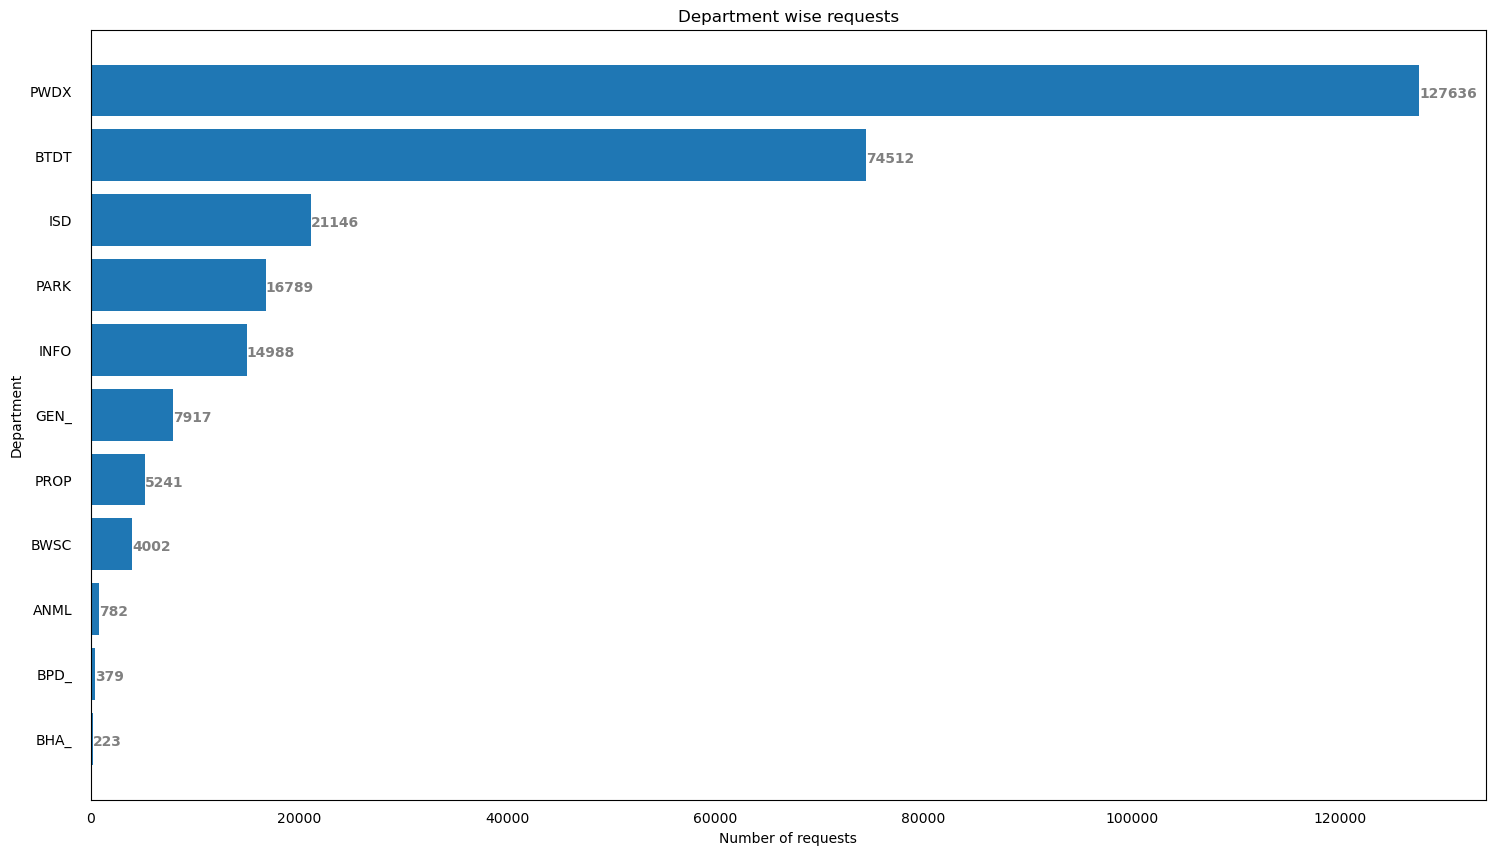

In [23]:
#Plot Graph
#fetching the values into a variable.
source = deptreq['index'].str.upper()
numberofrequests = deptreq['department']

fig1, ax1 = plt.subplots(figsize=(18, 10))

ax1.barh(source,numberofrequests)
    
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax1.xaxis.set_tick_params(pad=5)
ax1.yaxis.set_tick_params(pad=10)


ax1.invert_yaxis()


for i in ax1.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
ax1.set_ylabel('Department')
ax1.set_xlabel('Number of requests')
ax1.set_title('Department wise requests',
             loc='center')

# Show Plot
#plt.show()
plt.savefig('departmentwise-inflow.png')

## Requests' average turnaround time

In [24]:
service_request_df[(service_request_df['case_status'] == 'closed')]['aprx_days'].mean()

Timedelta('7 days 13:48:09.775866366')

In [25]:
avgturnaround= service_request_df[(service_request_df['case_status'] != 'open')][['department','aprx_days']].groupby(['department']).mean().reset_index().sort_values(by = ['aprx_days'])[4:15]
avgturnaround

,department,aprx_days
0,anml,1 days 09:46:38.779439252
2,bpd_,2 days 00:39:42.105263157
3,bps_,2 days 17:26:13.897435897
15,pwdx,3 days 22:09:28.878723980
4,btdt,5 days 03:05:34.713093855
9,info,7 days 17:08:13.255108855
6,disb,9 days 07:54:03.285714285
5,bwsc,10 days 23:55:00.634564643
10,isd,23 days 21:47:41.529179395
13,park,25 days 08:34:48.359750412


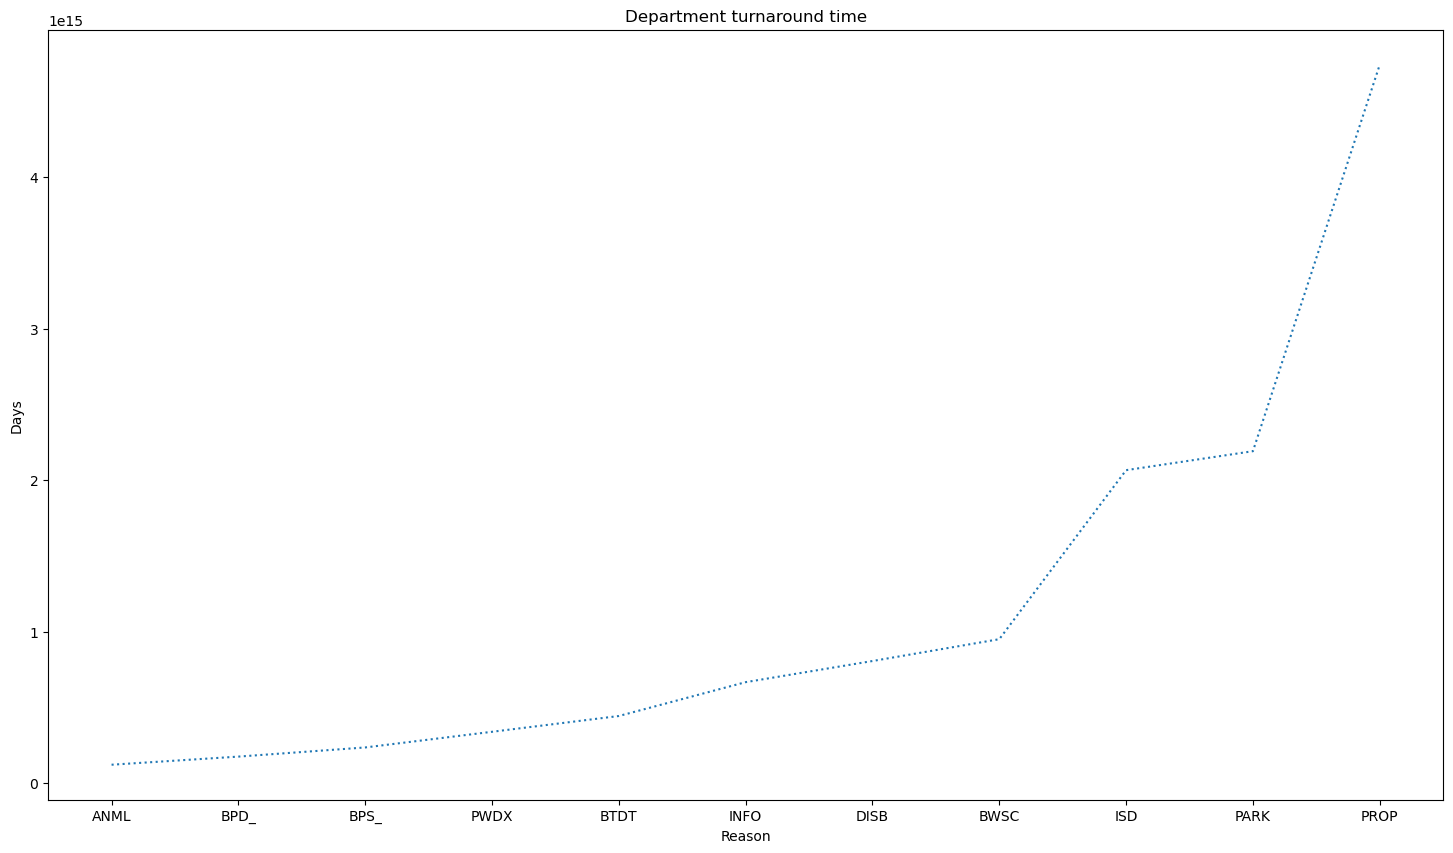

In [26]:
x = avgturnaround['department'].str.upper()
y = avgturnaround['aprx_days']
fig1, ax2 = plt.subplots(figsize=(18, 10))
plt.plot(x,y, linestyle = 'dotted')
ax2.set_ylabel('Days')
ax2.set_xlabel('Reason')
ax2.set_title('Department turnaround time',
             loc='center')
filename = 'department-turnaround-time'
plt.savefig(filename+'.png', facecolor=facecolor)

Here Animal Control had the least whereas the property management department had the higest turnaround time. We can observe a sharp rise in turnaound time between Park management and Property Management department.

## Top Request Reasons

There are 45 total request reasons, with the top 5 displayed in the Pie chart below. With 26%, the most common requests are for enforcement and abandoned vehicles, followed by 16% for street cleaning. All of the other justifications have been consolidated into a single variable called 'others.'

In [28]:
#Capturing top 10 reasons and storing it into a new dataframe.
topservicerequest_reason = service_request_df['reason'].value_counts().reset_index().rename(columns = {'index' : 'Reason','reason': 'values_count'}).sort_values('values_count',ascending = False)[0:11]
reason_sum = topservicerequest_reason['values_count'].sum()
topservicerequest_reason['percentage_share'] = round((topservicerequest_reason['values_count']/reason_sum) * 100)

topreasondf = topservicerequest_reason[:5]

#others
new_row = pd.DataFrame(data = {
    'Reason' : ['others'],
    'values_count' : [topservicerequest_reason['values_count'][5:].sum()]
})
#combining top 5 with others
topreasondf = pd.concat([topreasondf, new_row])

reason_sum = topreasondf['values_count'].sum()
topreasondf['percentage_share'] = round((topreasondf['values_count']/reason_sum) * 100)
topreasondf

,Reason,values_count,percentage_share
0,enforcement & abandoned vehicles,62506,26.0
1,street cleaning,37609,16.0
2,sanitation,31155,13.0
3,code enforcement,24542,10.0
4,highway maintenance,22489,10.0
0,others,57951,25.0


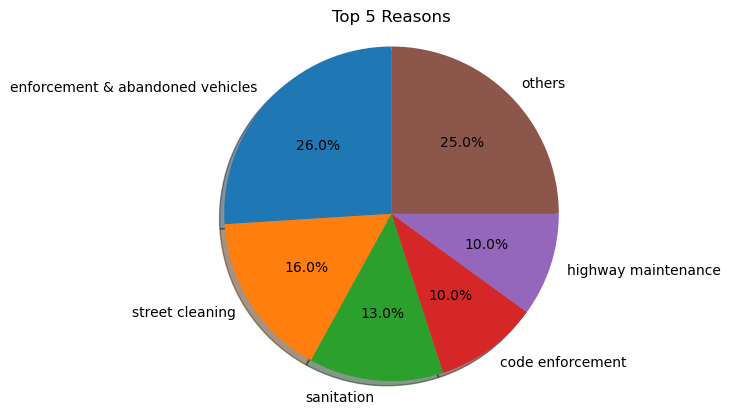

In [29]:
 #Plotting Pie Graph
fig1, ax1 = plt.subplots()
ax1.pie(topreasondf['percentage_share'], labels=topreasondf['Reason'],autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Top 5 Reasons')
filename = 'top-reasons'
plt.savefig(filename+'.png', facecolor=facecolor) 

There are 45 total request reasons, with the top 5 displayed in the Pie chart below. With 26%, the most common requests are for enforcement and abandoned vehicles, followed by 16% for street cleaning. All of the other justifications have been consolidated into a single variable called 'others.'

## In-Depth analysis of the top request i.e Traffic Violation

Traffic violations are the most common type of crime in Boston. In this section, we will look at the different types of traffic violations and where they occur the most. There are two categories of traffic violation one is ‘Parking enforcement’ which amounts to 92% of the violation and another is abandoned vehicles that amounts to 8%

In [30]:
topreason1df = service_request_df['type'][service_request_df['reason'] == 'enforcement & abandoned vehicles'].value_counts().reset_index().rename(columns = {'indext':'Type', 'type':'value_count'})
topreason1df.reset_index()
#topreason1df[topreason1df['value_count'] > 0 ]
topreason1df.rename(columns={'index': 'Violation', 'value_count': 'incidents_reported'},inplace = True)
summ = topreason1df['incidents_reported'].sum()
topreason1df['percentage_share'] = round(topreason1df['incidents_reported']/summ * 100)
topreason1df

,Violation,incidents_reported,percentage_share
0,parking enforcement,57418,92.0
1,abandoned vehicles,5088,8.0


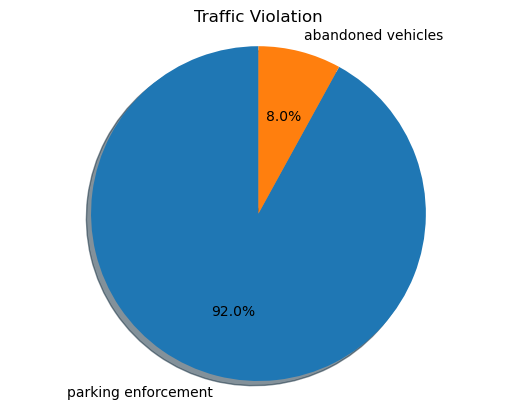

In [31]:
fig111, ax111 = plt.subplots()
ax111.pie(topreason1df['percentage_share'], labels=topreason1df['Violation'],autopct='%1.1f%%',shadow=True, startangle=90)
ax111.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
ax111.set_title('Traffic Violation')
filename = 'traffic-violation'
plt.savefig(filename+'.png', facecolor=facecolor)

### Parking Enforcement

Parking Enforcement refers to the issuance of parking tickets or citations for violations of the Parking Rules and Regulations governing Metered Parking Spaces, Non-Metered Parking Spaces, Residential Permits, and other Metro laws governing parking meters in effect at the time.<br>
Here I am using BOSTON neighborhood data to plot the records.

In [33]:
pe_neighborhooddf = service_request_df[(service_request_df['type'] == 'parking enforcement') & (service_request_df['neighborhood'].isna() == False)]['neighborhood'].value_counts().reset_index().rename(columns = {'index' : 'neighborhood', 'neighborhood' : 'total_violation'}).sort_values(by ='total_violation',ascending = False)
pe_neighborhooddf_time = service_request_df[(service_request_df['type'] == 'parking enforcement') & (service_request_df['neighborhood'].isna() == False)][['neighborhood','open_dt']]
#pe_neighborhooddf = pe_neighborhooddf.str.lower()
pe_neighborhooddf['neighborhood'] = pe_neighborhooddf['neighborhood'].str.lower()

df_places.rename(columns = {'Name' : 'neighborhood'},inplace = True)

import geopandas as gpd
#read in once
df_places = gpd.read_file('Boston_Neighborhoods.geojson')
df_places.Name = df_places.Name.str.lower()
df_places.rename(columns = {'Name' : 'neighborhood'},inplace = True)

df_places.neighborhood.replace('south boston','south boston / south boston waterfront',inplace = True)
df_places.neighborhood.replace('south boston waterfront','south boston / south boston waterfront',inplace = True)
df_places.neighborhood.replace('allston','allston / brighton',inplace = True)
df_places.neighborhood.replace('brighton','allston / brighton',inplace = True)
df_places.neighborhood.replace('downtown','downtown / financial district',inplace = True)
df_places.neighborhood.replace('financial district','downtown / financial district',inplace = True)
df_places.neighborhood.replace('fenway','fenway / kenmore / audubon circle / longwood',inplace = True)
df_places.neighborhood.replace('audubon circle','fenway / kenmore / audubon circle / longwood',inplace = True)
df_places.neighborhood.replace('Audubon Circle','fenway / kenmore / audubon circle / longwood',inplace = True)
df_places.neighborhood.replace('longwood','fenway / kenmore / audubon circle / longwood',inplace = True)

df_places = pd.merge(left = df_places,
                     right = pe_neighborhooddf,
                    left_on = 'neighborhood',
                    right_on = 'neighborhood',
                    how = 'left')
df_places.info()
df_places.dropna()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   OBJECTID         26 non-null     int64   
 1   neighborhood     26 non-null     object  
 2   Acres            26 non-null     float64 
 3   Neighborhood_ID  26 non-null     object  
 4   SqMiles          26 non-null     float64 
 5   ShapeSTArea      26 non-null     float64 
 6   ShapeSTLength    26 non-null     float64 
 7   geometry         26 non-null     geometry
 8   total_violation  20 non-null     float64 
dtypes: float64(5), geometry(1), int64(1), object(2)
memory usage: 2.0+ KB


,OBJECTID,neighborhood,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry,total_violation
0,27,roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ...",1241.0
1,28,jamaica plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326...",2683.0
2,29,mission hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335...",900.0
3,30,fenway / kenmore / audubon circle / longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337...",784.0
8,35,roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((-71.09646 42.29323, -71.09633 42.293...",2993.0
9,36,south end,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((-71.06834 42.34775, -71.06913 42.347...",3501.0
10,37,back bay,399.314411,2,0.62,1.739407e+07,19455.671146,"POLYGON ((-71.07569 42.35692, -71.07571 42.356...",2600.0
11,38,east boston,3012.059593,8,4.71,1.313845e+08,121089.100852,"POLYGON ((-70.99546 42.39394, -70.99557 42.394...",7117.0
12,39,charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39051, -71.07417 ...",3317.0
14,41,beacon hill,200.156904,30,0.31,8.718800e+06,14303.829017,"POLYGON ((-71.07141 42.36119, -71.07308 42.361...",1087.0


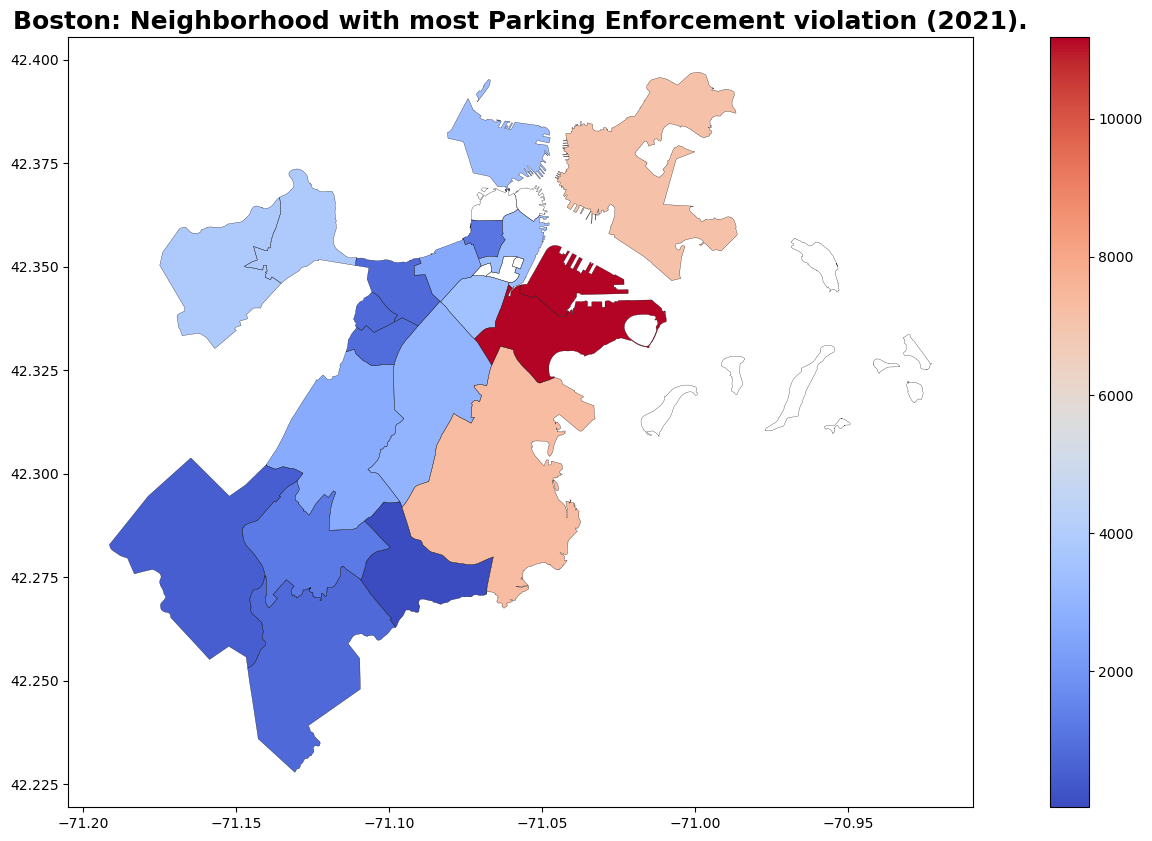

In [34]:
ax = df_places.boundary.plot(edgecolor = 'black',linewidth = 0.2,figsize=(20,10))
ax.set_title('Boston: Neighborhood with most Parking Enforcement violation (2021).', size = 18,weight = 'bold')
df_places.plot(ax = ax, column = 'total_violation',legend = True,cmap = 'coolwarm')
filename = 'neighborhood-with-most-parking-enforcement_violation'
plt.savefig(filename+'.png', facecolor=facecolor)

South Boston has the most violations since it is the most popular district with huge, modern restaurants, bars, and hotels.

### Vehicle Abandoned

The City of Boston has the legal authority to seize vehicles that have been left on City roadways for longer than 72 hours. Authorities implement this law if a resident complains or if the vehicle poses a safety danger.

In [35]:
av_neighborhooddf = service_request_df[(service_request_df['type'] == 'abandoned vehicles') & (service_request_df['neighborhood'].isna() == False)]['neighborhood'].value_counts().reset_index().rename(columns = {'index' : 'neighborhood', 'neighborhood' : 'total_violation_av'}).sort_values(by ='total_violation_av',ascending = False)
av_neighborhooddf11 = service_request_df[(service_request_df['type'] == 'abandoned vehicles') & (service_request_df['neighborhood'].isna() == False)][['neighborhood','open_dt']]
av_neighborhooddf.neighborhood = av_neighborhooddf.neighborhood.str.lower()

df_places = pd.merge(left = df_places,
                     right = av_neighborhooddf,
                    left_on = 'neighborhood',
                    right_on = 'neighborhood',
                    how = 'left')
df_places.info()
df_places.dropna()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   OBJECTID            26 non-null     int64   
 1   neighborhood        26 non-null     object  
 2   Acres               26 non-null     float64 
 3   Neighborhood_ID     26 non-null     object  
 4   SqMiles             26 non-null     float64 
 5   ShapeSTArea         26 non-null     float64 
 6   ShapeSTLength       26 non-null     float64 
 7   geometry            26 non-null     geometry
 8   total_violation     20 non-null     float64 
 9   total_violation_av  20 non-null     float64 
dtypes: float64(6), geometry(1), int64(1), object(2)
memory usage: 2.2+ KB


,OBJECTID,neighborhood,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry,total_violation,total_violation_av
0,27,roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ...",1241.0,340.0
1,28,jamaica plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326...",2683.0,395.0
2,29,mission hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335...",900.0,41.0
3,30,fenway / kenmore / audubon circle / longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337...",784.0,25.0
8,35,roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((-71.09646 42.29323, -71.09633 42.293...",2993.0,757.0
9,36,south end,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((-71.06834 42.34775, -71.06913 42.347...",3501.0,65.0
10,37,back bay,399.314411,2,0.62,1.739407e+07,19455.671146,"POLYGON ((-71.07569 42.35692, -71.07571 42.356...",2600.0,41.0
11,38,east boston,3012.059593,8,4.71,1.313845e+08,121089.100852,"POLYGON ((-70.99546 42.39394, -70.99557 42.394...",7117.0,198.0
12,39,charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39051, -71.07417 ...",3317.0,90.0
14,41,beacon hill,200.156904,30,0.31,8.718800e+06,14303.829017,"POLYGON ((-71.07141 42.36119, -71.07308 42.361...",1087.0,20.0


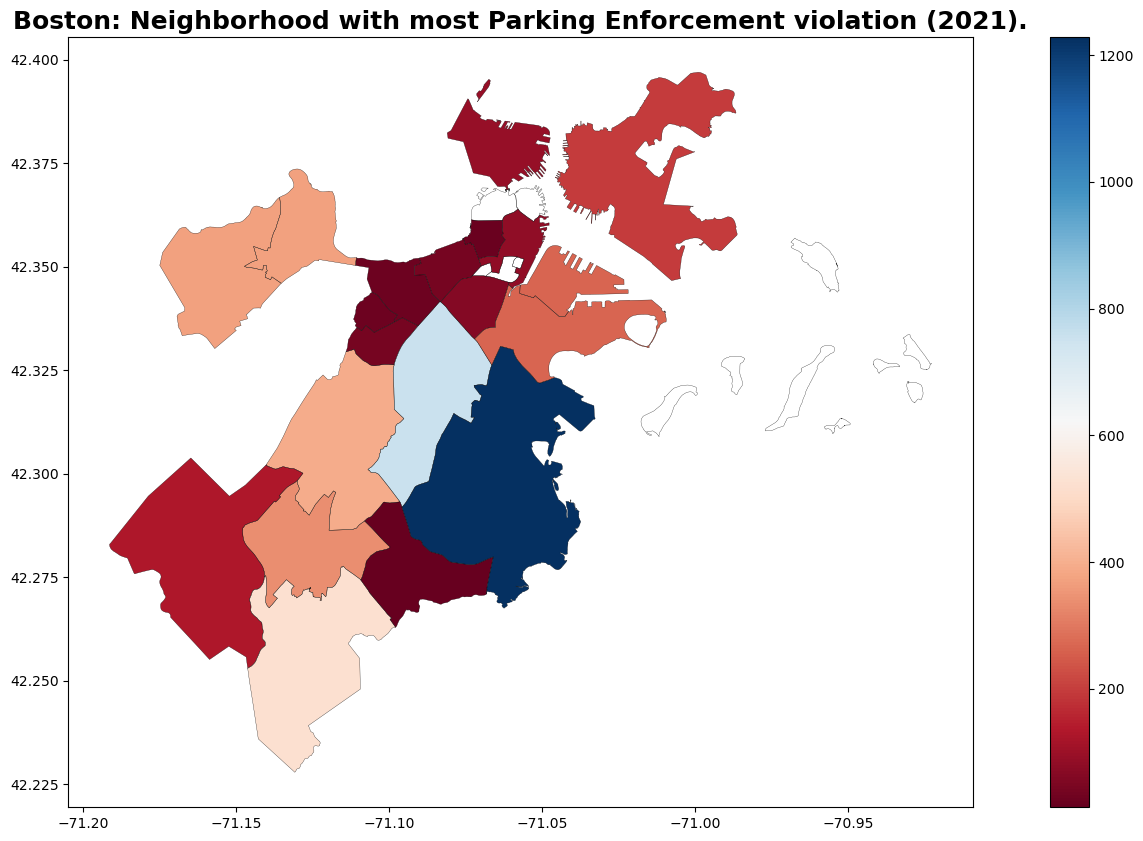

In [36]:
ax = df_places.boundary.plot(edgecolor = 'black',linewidth = 0.2,figsize=(20,10))
ax.set_title('Boston: Neighborhood with most Parking Enforcement violation (2021).', size = 18,weight = 'bold')
df_places.plot(ax = ax, column = 'total_violation_av',legend = True,cmap = 'RdBu')
filename = 'neighborhood-with-most-abandoned_vehicle'
plt.savefig(filename+'.png', facecolor=facecolor)

In Dorchester, there were 1228 reports of abandoned vehicles. This helped Boston in generating $1.2 million in revenue.

# Conclusion

Below are the answers to the objectives set at the start of the project
1.	Citizen App is the most common way to raise requests.
2.	On average 751 requests are submitted.
3.	Department with the least turnaround time is Animal control and the highest is Property Management.
4.	The request most reported are for Traffic violations which in turn helped to generate a ton of revenue for the council.
